# ERA5 Precipitation Analysis

## 27/10/25

This notebook's main purpose is to explore the application of our previous ERA5 temperature analysis to ERA5 precipitation values. In principle, the analysis should look much the same, with the difference lying in treating the data as cumulative rather than averages (averages works well for temperature, but not for precipitation).

The notebook is seperated into 3 sections:

1. Data Inspection
    - Inspecting the data do understand fully what it represents
1. Maps
    - Comparing a map of temperature and precipitation (averaged over all years)
    - Comparing maps of precipitation in each season of 2022
1. Linear Plots
    - Creating and comparing plots of:
        1. Precipitaion in each season
        1. Precipitation in Northern and Southern UK
1. Histograms
    - Creating and comparing plots for precipitation for all years before 1990 and all years after (and including) 1990

All sections make use of the same simple file with the following attributes:
- ERA5-Land monthly averaged data from 1950 to present
- Product type: Monthly averaged reanalysis
- Variables: 2m temperature, Total precipitation
- Years: All available (1950-2025)
- Months: All months (2025 data only reaches September)
- Time: 00:00 (Not relevent as monthly averaged reanalysis)
- Geographical area: North: 61°, West: -8°, South: 49°, East: 2°
- Data format: NetCDF4
- Size: 25.4


## 1. Data Inspection

Before delving to the data-analysis we first need to understand the data. The precipitation veriable we are looking at is simply called "Total Precipitation" on the ERA5 website with no reference to a timeframe. Our first task is then to figure out if the data refers to total daily, weekly, monthly or annual precipitation.

A closer look into the documentation uncovers the following:

"The hydrological parameters are in units of 'm of water equivalent per day' and so they should be multiplied by 1000 to convert to kgm-2day-1 or mmday-1"

It is clear then that the data is in the format of average meters of rainfall per day and should be multiplied by the number of days in a month to find the total rainfal for that month (in meters, multiplying again by 1000 converts to mm).

To double check this I cross referenced the ERA5 dataset with MetOffice data for a chosen month of rainfall (I chose September 2025 as it is the last full month of data available at the time of making this notebook).

ERA5-Land 2025/09: 105.1 mm, Met Office: 120.1 mm


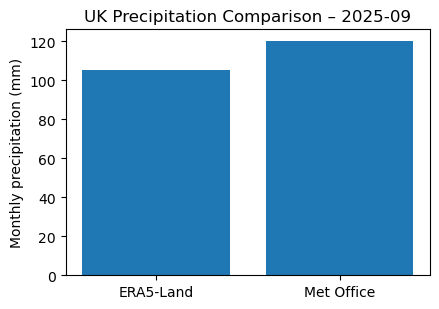

In [42]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Loading dataset
data_path = Path(r"C:\Users\itsna\OneDrive\Desktop\MSc Work\DataSets\temp_precipitation_uk.nc")
ds = xr.open_dataset(data_path)

# Variable names
time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"
tp = ds["tp"]

# Time array
t = pd.to_datetime(ds[time_name].values)

# Converting m to mm and daily to monthly
tp_mm_day = tp * 1000.0
days_in_month = xr.DataArray(t.days_in_month, coords={time_name: ds[time_name]}, dims=[time_name])
tp_mm_month = (tp_mm_day * days_in_month).mean(dim=(lat_name, lon_name), skipna=True)  # 1D over time

# Comparing to Met Office data (120.1 mm for September 2025)
year, month = 2025, 9
mask = (t.year == year) & (t.month == month)
if not mask.any():
    raise ValueError(f"No data for {year}-{month:02d} in this file.")
era5_val = float(tp_mm_month.sel({time_name: ds[time_name][mask]}).item())
metoffice_val = 120.1
print(f"ERA5-Land {year}/{month:02d}: {era5_val:.1f} mm, Met Office: {metoffice_val:.1f} mm")

# Comparison plot
plt.figure(figsize=(4.5,3.2))
plt.bar(["ERA5-Land", "Met Office"], [era5_val, metoffice_val])
plt.ylabel("Monthly precipitation (mm)")
plt.title(f"UK Precipitation Comparison – {year}-{month:02d}")
plt.tight_layout()
plt.show()


It is clear that the MetOffice value (120.1mm) and ERA5 value (105.1mm) are close enough to confirm our suspicions: ERA5 "Total Precipitation" values are in units of m of rainfall per day and multiplying by the number of days in a month returns the total precipitation in that month (in meters). Any difference between the two values is likely a result of the MetOffice using only observed data and ERA5 using a mix of observed and modelled values.

## 2. Maps

With the data format defined we are now free to apply the previous ERA5 analysis notebooks to this new variable.

### 2.1. Temperature vs Precipitation

To start, I created a simple map of 2m temperature averaged over all years (as before) alongside the total monthly precipitation averaged over all years.

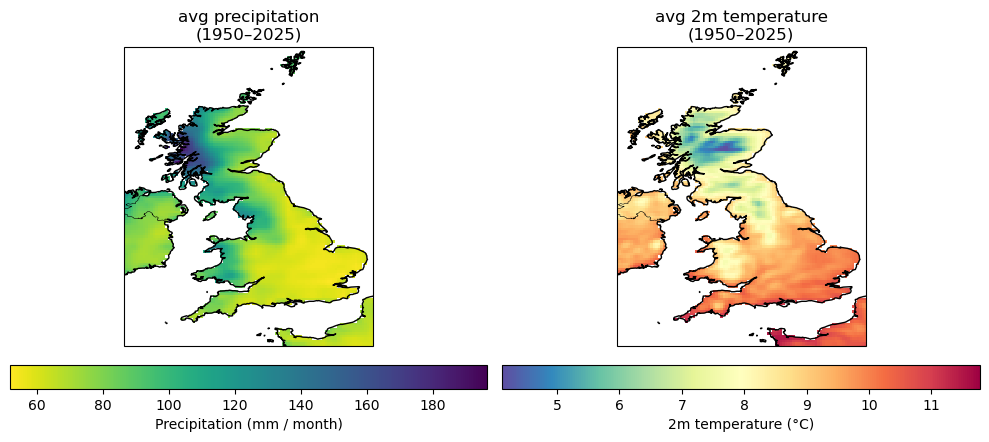

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd

# Colormap
precip_cmap = "viridis_r"
temp_cmap   = "Spectral_r"

t = pd.to_datetime(ds["valid_time"].values)
days_in_month = xr.DataArray(
    t.days_in_month,
    coords={"valid_time": ds["valid_time"]},
    dims=["valid_time"]
)

# Precipitation: m/day → mm/day → mm/month → mean over time
tp_mm_day = ds["tp"] * 1000.0
tp_mm_month = tp_mm_day * days_in_month
tp_clim = tp_mm_month.mean(dim="valid_time")

# Converting to celsius
t2m_c = ds["t2m"] - 273.15
t2m_clim = t2m_c.mean(dim="valid_time")

lats = ds["latitude"]
lons = ds["longitude"]

proj = ccrs.PlateCarree()

fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 4.5),
    subplot_kw={"projection": proj}
)

# Avg precipitation
ax = axes[0]
pc = ax.pcolormesh(
    lons,
    lats,
    tp_clim,
    cmap=precip_cmap,
    transform=proj
)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_extent([-8, 2, 49, 61], crs=proj)
cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
cb.set_label("Precipitation (mm / month)")
ax.set_title("avg precipitation\n(1950–2025)")

# Avg 2m temperature
ax = axes[1]
pc2 = ax.pcolormesh(
    lons,
    lats,
    t2m_clim,
    cmap=temp_cmap,
    transform=proj
)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_extent([-8, 2, 49, 61], crs=proj)
cb2 = plt.colorbar(pc2, ax=ax, orientation="horizontal", pad=0.05)
cb2.set_label("2m temperature (°C)")
ax.set_title("avg 2m temperature\n(1950–2025)")

plt.tight_layout()
plt.show()


It's interesting to see how temperature correlates to precipitation throughout the UK.

### 2.2. 2022 vs all years

The next goal was to create and compare maps for precipitation in 2022 vs the average of all years.

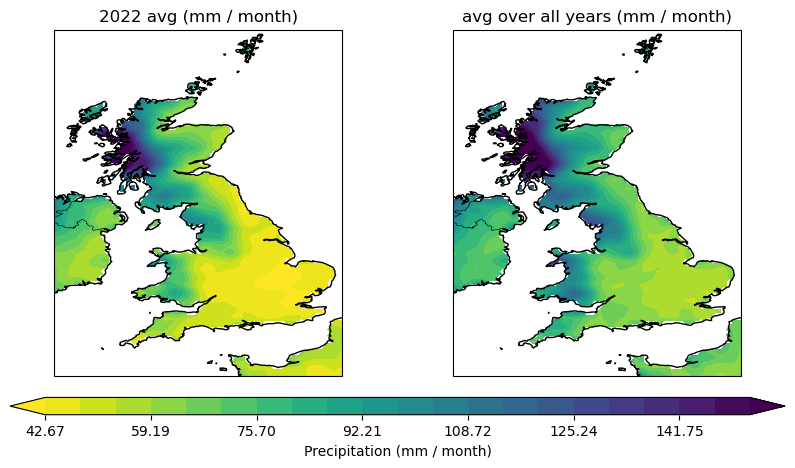

In [49]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np

# Choosing colourmap
colour_map = "viridis_r"

# Time array and month lengths
t = pd.to_datetime(ds["valid_time"].values)
days_in_month = xr.DataArray(
    t.days_in_month,
    coords={"valid_time": ds["valid_time"]},
    dims=["valid_time"]
)

# Converting precipitation to monthly totals (mm/month)
tp_mm_day = ds["tp"] * 1000.0
tp_mm_month = tp_mm_day * days_in_month

# Avg over all years
tp_clim = tp_mm_month.mean(dim="valid_time")

# 2022 avg
mask_2022 = (t.year == 2022)
tp_2022 = tp_mm_month.sel(valid_time=mask_2022).mean(dim="valid_time")

# Making masks
base = tp_mm_month.isel(valid_time=0).values
land_mask = np.isfinite(base) & (base != 0)

# Extracting as numpy
p2022 = tp_2022.values
pclim = tp_clim.values

# Applying mask so sea isnt plotted
p2022_m = np.ma.array(p2022, mask=~land_mask)
pclim_m = np.ma.array(pclim, mask=~land_mask)

# Shared colour range using only valid land cells
stack = np.concatenate([
    p2022[land_mask].ravel(),
    pclim[land_mask].ravel()
])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

lat = ds["latitude"].values
lon = ds["longitude"].values
proj = ccrs.PlateCarree()

# Getting cmap (fixes a warning message)
cmap = matplotlib.colormaps[colour_map].copy()
cmap.set_bad("lightgrey")

# Plotting subplots and horizontal colourbar
fig = plt.figure(figsize=(10, 5), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[20, 1], hspace=0.12, wspace=0.06)

ax_2022 = fig.add_subplot(gs[0, 0], projection=proj)
ax_clim = fig.add_subplot(gs[0, 1], projection=proj)
cax     = fig.add_subplot(gs[1, :])

for ax in (ax_2022, ax_clim):
    ax.set_extent([-8, 2, 49, 61])
    ax.coastlines(resolution="10m", color="black")
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)

cs1 = ax_2022.contourf(
    lon,
    lat,
    p2022_m,
    levels=levels,
    cmap=cmap,
    transform=proj,
    extend="both"
)
ax_2022.set_title("2022 avg (mm / month)")

cs2 = ax_clim.contourf(
    lon,
    lat,
    pclim_m,
    levels=levels,
    cmap=cmap,
    transform=proj,
    extend="both"
)
ax_clim.set_title("avg over all years (mm / month)")

cb = fig.colorbar(cs2, cax=cax, orientation="horizontal")
cb.set_label("Precipitation (mm / month)")

plt.show()


This shows that 2022 was a relatively dry year.

### 2.3. Four seasons

I then plotted the precipitation in 2022 for each season.

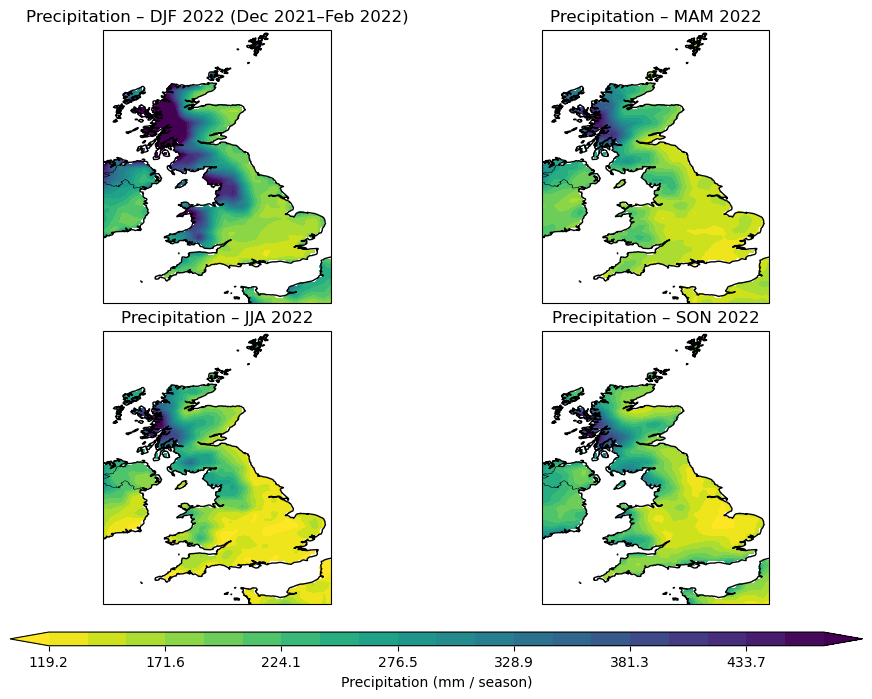

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np

# Choosing colourmap
colour_map = "viridis_r"

# Time array (for month lengths)
t = pd.to_datetime(ds["valid_time"].values)
days_in_month = xr.DataArray(
    t.days_in_month,
    coords={"valid_time": ds["valid_time"]},
    dims=["valid_time"]
)

# Converting to mm/month
tp_mm_day = ds["tp"] * 1000.0
tp_mm_month = tp_mm_day * days_in_month

# Defining seasons
def season_mask(year, season):
    if season == "DJF":
        return ((t.year == year - 1) & (t.month == 12)) | \
               ((t.year == year) & (t.month.isin([1, 2])))
    if season == "MAM":
        return (t.year == year) & (t.month.isin([3, 4, 5]))
    if season == "JJA":
        return (t.year == year) & (t.month.isin([6, 7, 8]))
    if season == "SON":
        return (t.year == year) & (t.month.isin([9, 10, 11]))
    raise ValueError("Unknown season name")

year = 2022

# Summing to get mm/season (skipna=True ifnores nan values)
djf = tp_mm_month.sel(valid_time=season_mask(year, "DJF")).sum(dim="valid_time", skipna=True)
mam = tp_mm_month.sel(valid_time=season_mask(year, "MAM")).sum(dim="valid_time", skipna=True)
jja = tp_mm_month.sel(valid_time=season_mask(year, "JJA")).sum(dim="valid_time", skipna=True)
son = tp_mm_month.sel(valid_time=season_mask(year, "SON")).sum(dim="valid_time", skipna=True)

# Making land mask (ignoring nan and 0 values)
base = tp_mm_month.isel(valid_time=0).values
land_mask = np.isfinite(base) & (base != 0)

djf_v = djf.values
mam_v = mam.values
jja_v = jja.values
son_v = son.values

# Applying the mask to every season
djf_m = np.ma.array(djf_v, mask=~land_mask)
mam_m = np.ma.array(mam_v, mask=~land_mask)
jja_m = np.ma.array(jja_v, mask=~land_mask)
son_m = np.ma.array(son_v, mask=~land_mask)

# Creating stacked array for colour limits
stack = np.concatenate([
    djf_v[land_mask].ravel(),
    mam_v[land_mask].ravel(),
    jja_v[land_mask].ravel(),
    son_v[land_mask].ravel()
])

vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

lat = ds["latitude"].values
lon = ds["longitude"].values
proj = ccrs.PlateCarree()

# Subplots and colourbar
fig = plt.figure(figsize=(11, 8), constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[20, 20, 1], hspace=0.15, wspace=0.06)

ax_djf = fig.add_subplot(gs[0, 0], projection=proj)
ax_mam = fig.add_subplot(gs[0, 1], projection=proj)
ax_jja = fig.add_subplot(gs[1, 0], projection=proj)
ax_son = fig.add_subplot(gs[1, 1], projection=proj)
cax    = fig.add_subplot(gs[2, :])

for ax in (ax_djf, ax_mam, ax_jja, ax_son):
    ax.set_extent([-8, 2, 49, 61])
    ax.coastlines(resolution="10m", color="black")
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)

# Plotting each panel
cs_djf = ax_djf.contourf(lon, lat, djf_m, levels=levels, cmap=cmap,
                         transform=proj, extend="both")
ax_djf.set_title("Precipitation – DJF 2022 (Dec 2021–Feb 2022)")

cs_mam = ax_mam.contourf(lon, lat, mam_m, levels=levels, cmap=cmap,
                         transform=proj, extend="both")
ax_mam.set_title("Precipitation – MAM 2022")

cs_jja = ax_jja.contourf(lon, lat, jja_m, levels=levels, cmap=cmap,
                         transform=proj, extend="both")
ax_jja.set_title("Precipitation – JJA 2022")

cs_son = ax_son.contourf(lon, lat, son_m, levels=levels, cmap=cmap,
                         transform=proj, extend="both")
ax_son.set_title("Precipitation – SON 2022")

# Colourbar
cb = fig.colorbar(cs_son, cax=cax, orientation="horizontal")
cb.set_label("Precipitation (mm / season)")

plt.show()


## 3. Linear Plots

I then made linear plots for each season (with no sigma value such that the uncertainties are driven by the residuals). Originally I plotted each season on the same plot but I ended up seperating them for clarity.

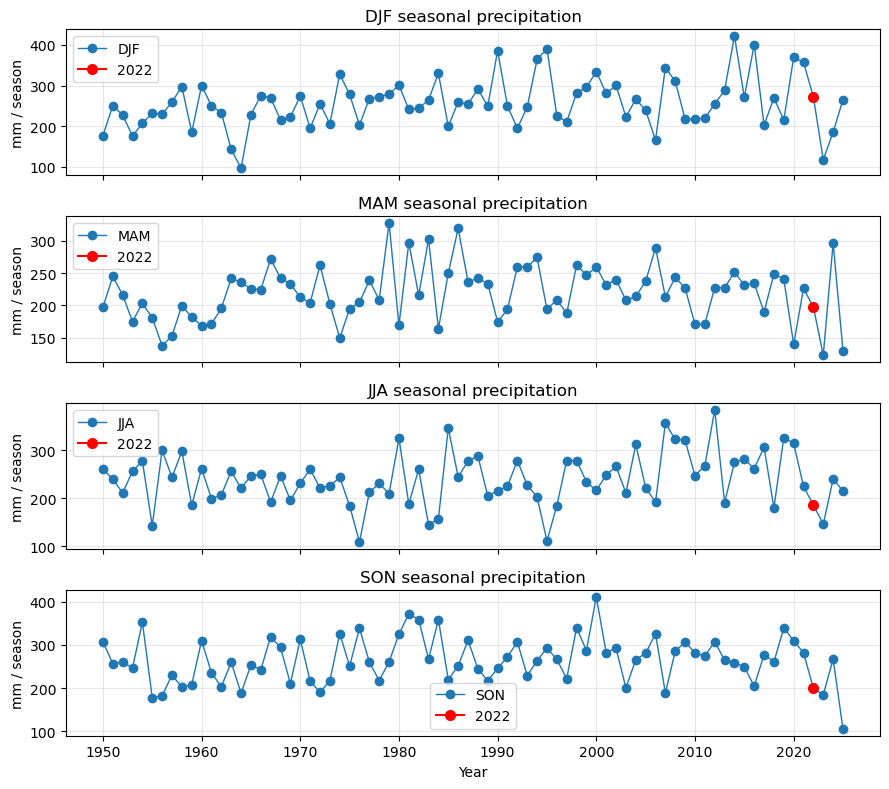

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Time array
t = pd.to_datetime(ds["valid_time"].values)
days_in_month = t.days_in_month.to_numpy()

# Converting to mm/month
tp = ds["tp"].values
tp_mm_day = tp * 1000.0
tp_mm_month = tp_mm_day * days_in_month[:, None, None]

# UK avg precipitation for each month
tp_uk_month = np.nanmean(tp_mm_month, axis=(1, 2))

# Putting in DataFrame
df = pd.DataFrame({
    "date": t,
    "precip_mm_month": tp_uk_month
})
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

# Assigning seasons (Dec goes to next year DJF)
def season_label(m):
    if m in (12, 1, 2): return "DJF"
    if m in (3, 4, 5):  return "MAM"
    if m in (6, 7, 8):  return "JJA"
    return "SON"

df["season"] = df["month"].apply(season_label)

# Season-year
df["season_year"] = df["year"]
df.loc[df["month"] == 12, "season_year"] = df.loc[df["month"] == 12, "year"] + 1

# Summing monthly totals to seasonal totals
seasonal = (
    df.groupby(["season_year", "season"])["precip_mm_month"]
      .sum()
      .reset_index()
      .rename(columns={"precip_mm_month": "precip_mm_season"})
)

# To make plotting easier pivoting to columns DJF/MAM/JJA/SON
seasonal_wide = seasonal.pivot(index="season_year", columns="season", values="precip_mm_season").sort_index()

# Dropping rows with nan values (incomplete seasons)
seasonal_wide = seasonal_wide.dropna(how="all")

fig, axes = plt.subplots(4, 1, figsize=(9, 8), sharex=True)

seasons = ["DJF", "MAM", "JJA", "SON"]
for ax, s in zip(axes, seasons):
    ax.plot(
        seasonal_wide.index,
        seasonal_wide[s],
        marker="o",
        linewidth=1.0,
        label=s
    )
    # Highlighting 2022
    if 2022 in seasonal_wide.index:
        ax.plot(
            2022,
            seasonal_wide.loc[2022, s],
            marker="o",
            markersize=7,
            color="red",
            label="2022"
        )
    ax.set_ylabel("mm / season")
    ax.set_title(f"{s} seasonal precipitation")
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Year")

plt.tight_layout()
plt.show()


## 4. Histograms

Lastly I created a histogram for all the years before (and including) 1990 and all the years after.

Number of monthly entries < 1990: 480
Number of monthly entries ≥ 1990: 429


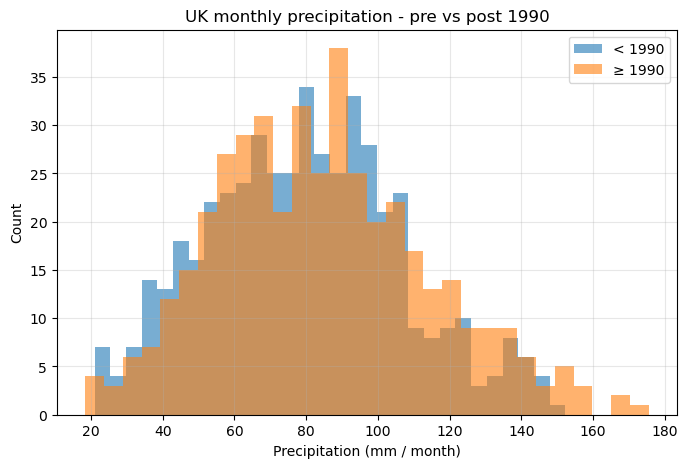

In [47]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Time and month lengths
time = pd.to_datetime(ds["valid_time"].values)
days_in_month = time.days_in_month.to_numpy()

# converting to mm/month
tp_m_day = ds["tp"].values
tp_mm_day = tp_m_day * 1000.0
tp_mm_month = tp_mm_day * days_in_month[:, None, None]

# monthly avg
tp_monthly_uk = np.nanmean(tp_mm_month, axis=(1, 2))

year = time.year.values

# Splitting into pre and post 1990
mask_pre  = year < 1990
mask_post = year >= 1990

precip_pre  = tp_monthly_uk[mask_pre]
precip_post = tp_monthly_uk[mask_post]

print(f"Number of monthly entries < 1990: {precip_pre.size}")
print(f"Number of monthly entries ≥ 1990: {precip_post.size}")

plt.figure(figsize=(8, 5))
bins = 30

plt.hist(precip_pre,  bins=bins, alpha=0.6, label="< 1990")
plt.hist(precip_post, bins=bins, alpha=0.6, label="≥ 1990")

plt.xlabel("Precipitation (mm / month)")
plt.ylabel("Count")
plt.title("UK monthly precipitation - pre vs post 1990")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
